### Fontes e referências:

Baseado em:

*Bayesian Analysis with Python: Introduction to statistical modeling and probabilistic programming using PyMC3 and ArviZ
Por Osvaldo Martin*
(Capítulo 1)

https://books.google.com.br/books?id=1Z2BDwAAQBAJ&pg=PA6&hl=pt-BR&source=gbs_toc_r&cad=3#v=onepage&q&f=false

https://github.com/PacktPublishing/Bayesian-Analysis-with-Python-Second-Edition

https://arviz-devs.github.io/arviz/generated/arviz.plot_posterior.html

Veja também:

http://www.pollingdata.com.br/bayes/

https://towardsdatascience.com/hands-on-bayesian-statistics-with-python-pymc3-arviz-499db9a59501

### Introdução

Pode-se resumir o processo de modelagem bayesiano em três passos:

- a partir dos dados e suposições sobre como eles foram gerados, obter distribuições de probabilidade (verossimilhança e priori)

- usar o teorema de Bayes para obter mais informações sobre o nosso modelo

- verificar se o modelo faz sentido de acordo com as suposições iniciais

*A abordagem baeysiana usa probabilidades como ferramenta para quantificar incerteza.*
*Em geral, não há como ter certeza se o modelo é correto; assim, é preciso avaliar o modelo para convencer de que ele é adequado para o problema que temos em mãos.*

### Teorema de Bayes

Da regra do produto, temos: $p(\theta,y) = p(\theta|y)p(y)$, que também pode ser escrita como $p(\theta,y) = p(y|\theta)p(\theta)$; assim, $p(\theta|y)p(y) = p(y|\theta)p(\theta)$. Reordenando os termos, segue que:

$$p(\theta|y) = \frac{p(y|\theta)p(\theta)}{p(y)}.$$

O teorema nos diz como calcular a probabilidade de uma hipótese $(\theta)$ dadas as observações $(y)$.

Definimos:

- $p(\theta)$: priori, deve refletir o conhecimento que temos sobre o valor do parâmetro $\theta$ antes de observar os dados);
- $p(y|\theta)$: verossimilhança, introduz os dados no modelo; expressa a plausibilidade das observações dado o parâmetro);
- $p(\theta|y)$: posteriori, é o resultado da análise bayesiana e reflete nosso conhecimento sobre o problema --- dadas as observações e o modelo; é uma distribuição para o parâmetro e não um único valor)
- $p(y)$: verossimilhança marginal (também chamada de evidência), é a probabilidade de observar os dados sob a média de todos os valores possíveis do parâmetros (como estabelecido pela priori); é uma constante de normalização, em geral ignorada, de onde segue:

$$p(\theta|y) \propto p(y|\theta)p(\theta).$$

*Probabilidades são usadas para mensurar a incerteza que temos sobre os parâmetros, e o teorema de Bayes é o mecanismo para atualizar corretamente essas probabilidades sob a luz de novos dados, esperançosamente reduzindo nossa incerteza.*

### Exemplo: lançamento de moeda

Considere a situação em que lançamos uma moeda um certo número de vezes e anotamos o quantas caras e coroas obtemos. Com base nesses dados, tentamos responder perguntas como: *a moeda é honesta?* Ou mais geralmente: *quão viesada é a moeda?*

Para estimar o viés da uma moeda, vamos assumir que os dados dos lançamentos já foram coletados.
Também vamos generalizar o conceito de viés: diremos que uma moeda com viés = 1 sempre terá resultado cara, uma com viés = 0 sempre terá resultado coroa e uma moeda com viés = 0,5 terá resultado cara metade das vezes e coroa metade das vezes.

O viés será representado pelo parâmetro $\theta$, e para representar o número total de caras em $N$ lançamentos usaremos a variável $y$.

**Verossimilhança**

Vamos supor que apenas dois resultados são possíveis --- cara ou coroa --- e assumir que um lançamento da moeda não afeta outro lançamento (lançamentos independentes). Também vamos assumir que todos os lançamentos de moeda vêm da mesma distribuição. Assim, $y$ é uma variável aleatória iid (independente e identicamente distribuída). Então, uma boa candidata a verossimilhaça é a distribuição binomial:

$$p(y|\theta,N) = \frac{N!}{y!(N-y)!}\theta^y(1-\theta)^{N-y},$$

que é a distribuição discreta que dá a probabilidade de obter $y$ caras (sucessos) em $N$ lançamentos (ensaios) dado um valor fixo de $\theta$.

In [6]:
# Instalação de pacote
# conda install -c conda-forge arviz

In [66]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import arviz as az

az.style.use('arviz-darkgrid')

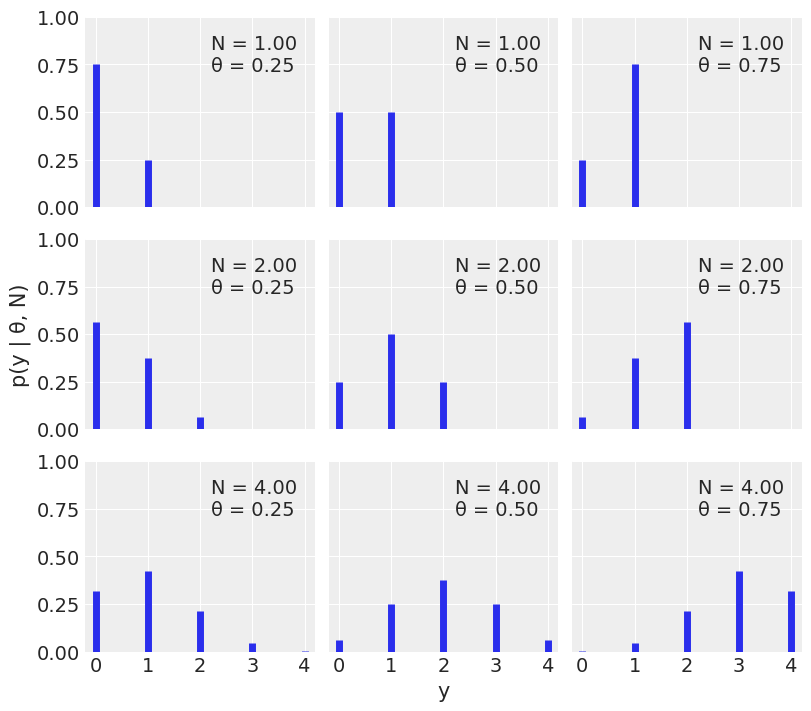

In [67]:
n_params = [1, 2, 4]  # Number of trials
p_params = [0.25, 0.5, 0.75]  # Probability of success

x = np.arange(0, max(n_params)+1)
f,ax = plt.subplots(len(n_params), len(p_params), sharex=True, sharey=True,
                    figsize=(8, 7), constrained_layout=True)

for i in range(len(n_params)):
    for j in range(len(p_params)):
        n = n_params[i]
        p = p_params[j]

        y = stats.binom(n=n, p=p).pmf(x)

        ax[i,j].vlines(x, 0, y, colors='C0', lw=5)
        ax[i,j].set_ylim(0, 1)
        ax[i,j].plot(0, 0, label="N = {:3.2f}\nθ = {:3.2f}".format(n,p), alpha=0)
        ax[i,j].legend()

        ax[2,1].set_xlabel('y')
        ax[1,0].set_ylabel('p(y | θ, N)')
        ax[0,0].set_xticks(x)

A figura acima mostra nove binomiais com diferentes valores para os parâmetros. A distribuição é razoável para a verossimilhança. Note que $\theta$ indica quão provável é obter cara no lançamento de uma moeda.

Se sabemos o valor de $\theta$, a distribuição binomial nos dirá a distribuição esperada de caras. Mas não conhecemos o valor de $\theta$; na abordagem bayesiana, quando não sabemos o valor do parâmetro, atribuímos uma priori para ele.

**Priori**

Uma das distribuições que podemos assumir para nossa priori é a $Beta(\alpha,\beta)$:

$$p(\theta) = \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha) \Gamma(\beta)}\theta^{\alpha-1}(1-\theta)^{\beta-1}.$$

Note que ela é similar à binomial, com excessão do primeiro termo. Uma das razões para essa escolha é que a Beta está entre -1 e 1, da mesma forma que $\theta$; outra razão é sua versatilidade, dado que pode assumir diferentes formas. Vamos observar tais formas (que incluem a distribuição uniforme e a gaussiana).

Text(0.07, 0.5, 'p(θ)')

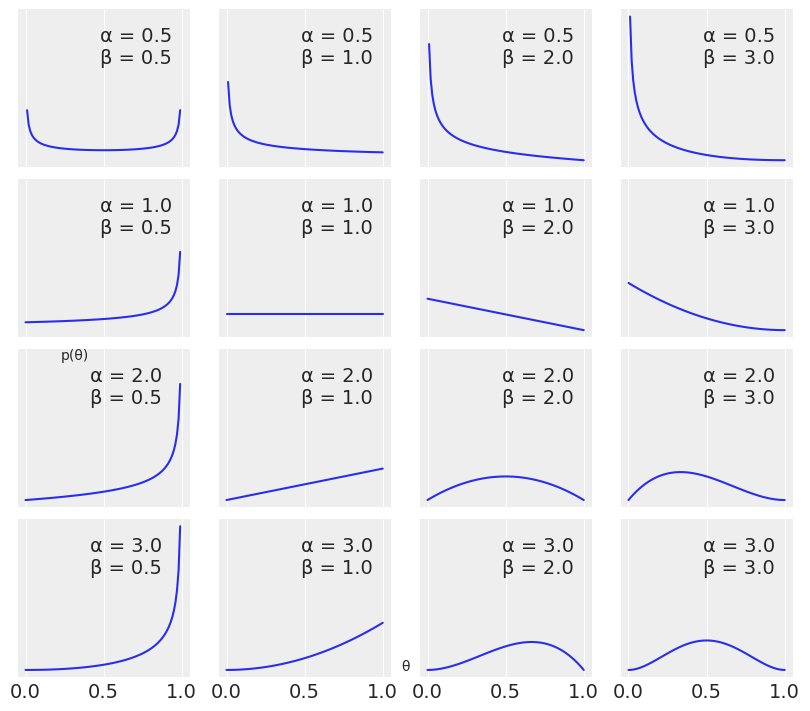

In [68]:
params = [0.5, 1, 2, 3]
x = np.linspace(0, 1, 100)
f, ax = plt.subplots(len(params), len(params), sharex=True, sharey=True,
                     figsize=(8, 7), constrained_layout=True)
for i in range(4):
    for j in range(4):
        a = params[i]
        b = params[j]
        y = stats.beta(a, b).pdf(x)
        ax[i,j].plot(x, y)
        ax[i,j].plot(0, 0, label="α = {:2.1f}\nβ = {:2.1f}".format(a, b), alpha=0)
        ax[i,j].legend()
ax[1,0].set_yticks([])
ax[1,0].set_xticks([0, 0.5, 1])
f.text(0.5, 0.05, 'θ', ha='center')
f.text(0.07, 0.5, 'p(θ)', va='center', rotation=0)

Outro motivo para a escolha da Beta é que ela é a priori conjugada da binomial --- uma priori conjugada de uma verossimilhança é uma priori que, quando usada em conjunto com uma verossimilhança dada, retorna uma posteriori com a mesma forma da priori. Então, toda vez que usamos uma priori Beta e uma verossimilhança binomial obtemos uma posteriori Beta.

**Posteriori**

Segundo o teorema de Bayes, a posteriori é proporcional à verossimilhança vezes a priori. Assim,

$$p(\theta|y) \propto \frac{N!}{y!(N-y)!}\theta^y(1-\theta)^{N-y}\frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha) \Gamma(\beta)}\theta^{\alpha-1}(1-\theta)^{\beta-1},$$

expressão que pode ser simplificada removendo-se os termos que não dependem de $\theta$:

$$p(\theta|y) \propto \theta^y(1-\theta)^{N-y}\theta^{\alpha-1}(1-\theta)^{\beta-1},$$

que nos leva à

$$p(\theta|y) \propto \theta^{y+\alpha-1}(1-\theta)^{N-y+\beta-1},$$

isto é,

$$p(\theta|y) \propto Beta(\alpha_{priori}+y,\beta_{priori}+N-y).$$

Vamos calcular e plotar essa posteriori.

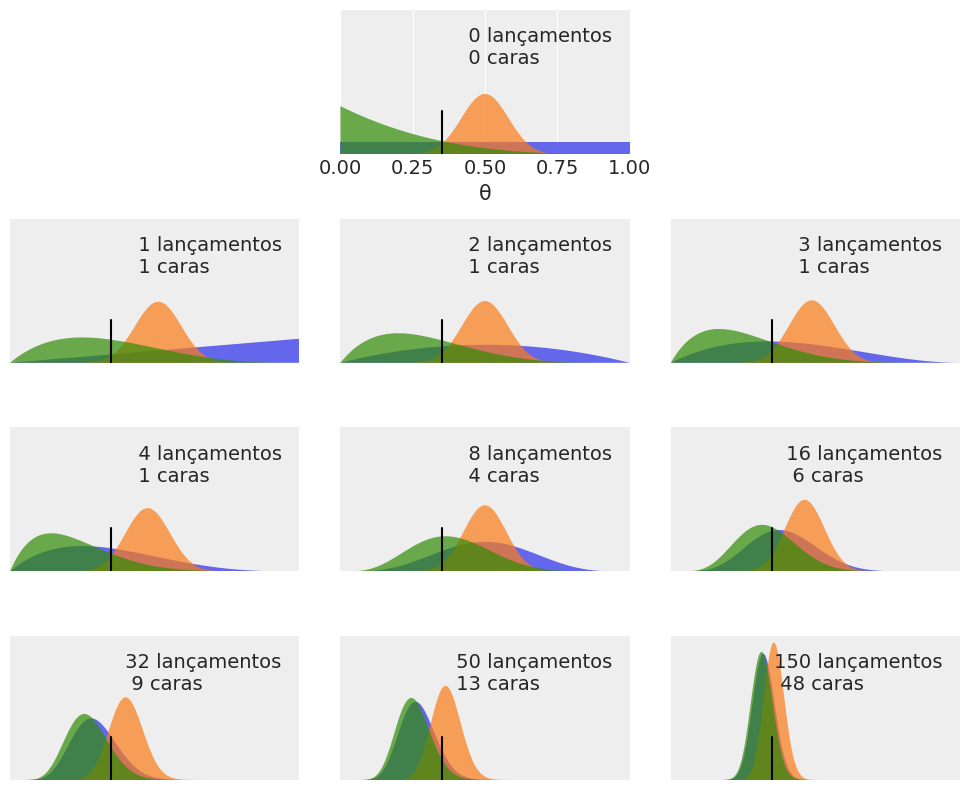

In [69]:
plt.figure(figsize=(10, 8))

n_trials = [0, 1, 2, 3, 4, 8, 16, 32, 50, 150]
data = [0, 1, 1, 1, 1, 4, 6, 9, 13, 48]
theta_real = 0.35 # valor real assumido para theta

beta_params = [(1, 1), (20, 20), (1, 4)]
dist = stats.beta
x = np.linspace(0, 1, 200)

for idx, N in enumerate(n_trials):
    if idx == 0:
        plt.subplot(4, 3, 2)
        plt.xlabel('θ')
    else:
        plt.subplot(4, 3, idx+3)
        plt.xticks([])
    y = data[idx]
    for (a_prior, b_prior) in beta_params:
        p_theta_given_y = dist.pdf(x, a_prior + y, b_prior + N - y) # Note que esta é a linha que calcula a posteriori
        plt.fill_between(x, 0, p_theta_given_y, alpha=0.7)

    plt.axvline(theta_real, ymax=0.3, color='k')
    plt.plot(0, 0, label=f'{N:4d} lançamentos\n{y:4d} caras', alpha=0)
    plt.xlim(0, 1)
    plt.ylim(0, 12)
    plt.legend()
    plt.yticks([])
plt.tight_layout()

No primeiro gráfico, não temos nenhum lançamento; assim as três curvas representam nossas prioris:

- priori uniforme (azul): representa todos os valores possíveis para o viés como equiprováveis a priori;

- priori gaussiana (laranja): centrada e concentrada em 0,5, compatível com a informação de que a moeda tem mais ou menos a mesma chance de ter resultado cara ou coroa (moeda honesta);

- priori assimétrica (verde): coloca mais peso em um resultado coroa.

Os demais gráficos mostra as distribuições a posteriori de lançamentos sucessivos. A linha vertical preta em 0,35 representa o verdadeiro valor de $\theta$ (que não é conhecido em situações reais.

O que podemos observar:

- o resultado da análise bayesiana é um conjunto de valores possíveis;

- o valor mais provável é a moda a posteriori (pico da distribuição);

- a amplitude da posteriori é proporcional à incerteza sobre o parâmetro (maior amplitude = maior incerteza);

- intuitivamente, confiamos mais em um resultado quando observamos mais dados que o corroboram; mesmo que $\frac{1}{2}=\frac{4}{8}=0,5$, confiamos mais que o viés é 0,5 quando observamos 4 caras em oito lançamentos que 1 cara em 2 lançamentos; isso se reflete na posteriori (azul) nos terceiro e sexto gráficos --- a moda é a mesma, mas a amplitude (incerteza) é maior no terceiro gráfico;

- dada uma quantidade suficientemente grande de dados, dois ou mais modelos com prioris diferentes tendem a convergir para o mesmo resultado;

- a velocidade de convergência da posteriori depende dos dados e do modelo; as posterioris que vêm da priori uniforme (azul) e da priori viesada relativamente a coroa (verde) convergem mais rapidamente para quase a mesma distribuição, enquanto leva mais tempo para a posteriori com os dados concentrados (laranja); na verdade, mesmo após 150 lançamentos, observa-se que esta posteriori (laranja) tem distribuição diferente das outras;

- algo que não fica evidente na figura é que o mesmo resultado é obtido ao atualizar a posteriori sequencialmente ou de uma única vez; isto é, podemos calcular a posteriori 150 vezes, em cada vez adicionando uma nova observação e usando a posteriori obtida como nova priori, ou calcular a posteriori para 150 lançamentos de uma única vez --- o resultado é exatamente o mesmo.

**Resultados**

O resultado de uma análise bayesiana é uma distribuição a posteriori e toda a informação sobre os parâmetros dado um conjunto de observações está na posteriori. Em geral, também destacamos para cada parâmetro sua média, moda ou mediana para termos ideia da estimativa pontual e uma medida de dispersão que fornece a incerteza da nossa estimativa. Uma dessas medidas é o intervalo de máxima densidade a posteriori (HPD - *Highest-Posterior Density* ou HDI - *Highest Density Interval*), que é o menor intervalo que contém dada porção da densidade de probabilidade, isto é, o IC (intervalo de credibilidade) de menor amplitude.

O HDI de 95% é [0.24514738 0.40213186]


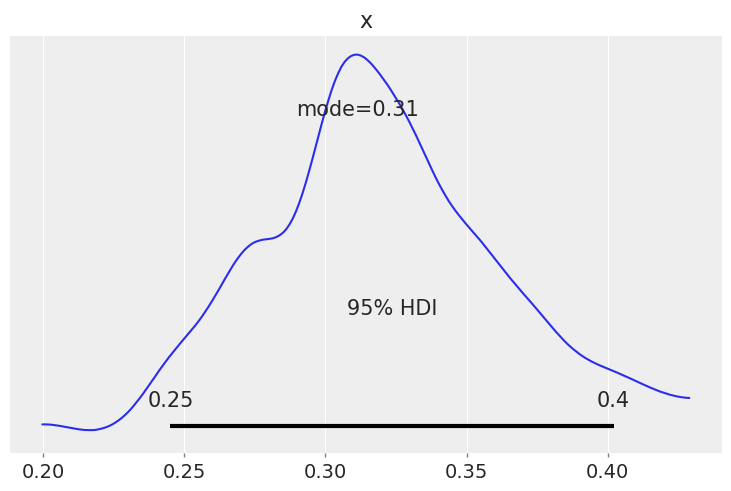

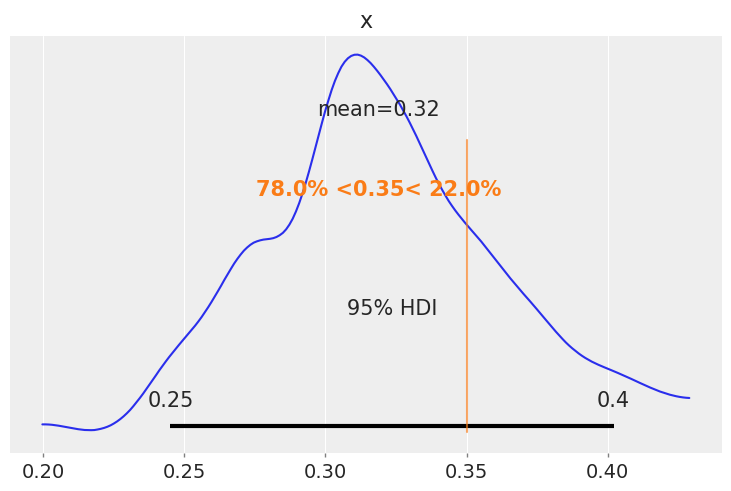

In [70]:
# geração de amostra aleatória com distribuição beta (último gráfico laranja)
np.random.seed(1)
data = stats.beta.rvs(49, 106, size=150) #testando N=150 lançamentos, y = 48 caras, priori beta(1,4)
ci = az.hdi(data, hdi_prob=.95)
print("O HDI de 95% é", ci) # note que o theta 'verdadeiro' assumido anteriormente = 0,35 está no intervalo
az.plot_posterior(data, point_estimate='mode', hdi_prob=.95);
az.plot_posterior(data, point_estimate='mean', hdi_prob=.95, ref_val=0.35);